# Importations

In [227]:
import mne
from load_xdf import data_path, event_id
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

# Load the EEG data
## find fif files
fif_files = [f for f in os.listdir(data_path) if f.endswith('.fif')]
fif_files
if fif_files == []:
    raise ValueError('No fif files found in the data folder')
file_name = Path(fif_files[0])
raw = mne.io.read_raw(data_path / file_name)

Opening raw data file D:\pro\emile_final_bci_preprocessed.fif...


C:\Users\Emile\AppData\Local\Temp\ipykernel_3260\1771589243.py:16: RuntimeWarning: This filename (D:\pro\emile_final_bci_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(data_path / file_name)


    Range : 0 ... 314649 =      0.000 ...   614.549 secs
Ready.


In [230]:
%matplotlib qt
raw.plot(scalings=dict(eeg=80e-6))
plt.show()

Channels marked as bad:
none


In [231]:
raw.get_montage().plot(show_names=True)
plt.show()

# ERP Analysis

In [232]:
# Remove ids that are not in the data
events  = mne.find_events(raw, stim_channel='STI')
event_id

Trigger channel STI has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
119 events found on stim channel STI
Event IDs: [120 122 130 150 155 200 201 203]


{'left_good': 120,
 'right_good': 122,
 'left_bad': 150,
 'right_bad': 155,
 'no_response': 130,
 'left': 140,
 'right': 141,
 'cross': 200,
 'stim': 201,
 'decision': 202,
 'feedback': 203,
 'rest': 204,
 'imagery': 205,
 'pause': 206}

In [233]:
event_id = {k: v for k, v in event_id.items() if v in events[:, 2]}
event_id

{'left_good': 120,
 'right_good': 122,
 'left_bad': 150,
 'right_bad': 155,
 'no_response': 130,
 'cross': 200,
 'stim': 201,
 'feedback': 203}

In [234]:
# Extract events
fig = mne.viz.plot_events(events, sfreq = raw.info['sfreq'], first_samp = raw.first_samp, event_id=event_id)
plt.show()

In [235]:
# Make metadata
columns = ['response']
metadata_df = pd.DataFrame(columns=columns)
response = []
for i in range(len(events)):
    if events[i, 2] in [120, 122, 130, 150, 155]:
        response.append(events[i, 2])
metadata_df['response'] = response

In [236]:
# Create epochs
event_id = {'feedback' : 203}
event_of_interest = 203
events = mne.pick_events(events, include=event_of_interest, exclude=None)
epochs = mne.Epochs(raw, events, event_id, tmin= -3, tmax= 1., preload=True, metadata=metadata_df, baseline = (-.3,-.1))

Adding metadata with 1 columns
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 2049 original time points ...
0 bad epochs dropped


In [237]:
%matplotlib qt
epochs.plot(n_epochs=10, n_channels=64)
plt.show()

Dropped 6 epochs: 3, 13, 14, 26, 27, 28
The following epochs were marked as bad and are dropped:
[3, 13, 14, 26, 27, 28]
Channels marked as bad:
none


In [238]:
ChOI = ['FCz', 'Cz','Fz', 'FC1', 'FC2'] # channel of interest
epochs = epochs.pick_channels(ChOI)
epochs = mne.channels.combine_channels(epochs, dict(Avg=list(range(len(epochs.ch_names)))))
epochs.filter(1,40)
epochs.apply_baseline((-.5,-.1))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Adding metadata with 1 columns
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Applying baseline correction (mode: mean)


C:\Users\Emile\AppData\Local\Temp\ipykernel_3260\1885067324.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs = epochs.pick_channels(ChOI)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Number of events,24
Events,feedback: 24
Time range,-3.000 – 1.000 s
Baseline,-0.500 – -0.100 s


In [239]:
%matplotlib qt
epochs.plot(n_epochs=10)
plt.show()  

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [240]:
wrong_feedback_epochs = epochs['response == 150 or response == 155 or response == 130']
correct_feedback_epochs = epochs['response == 120 or response == 122']
print('Number of wrong feedback epochs: ', len(wrong_feedback_epochs))
print('Number of correct feedback epochs: ', len(correct_feedback_epochs))

Number of wrong feedback epochs:  15
Number of correct feedback epochs:  9


C:\Users\Emile\AppData\Local\Temp\ipykernel_3260\3379366221.py:4: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds([wrong_feedback_epochs.average(), correct_feedback_epochs.average()], colors = ['red', 'blue'], show_sensors=True)


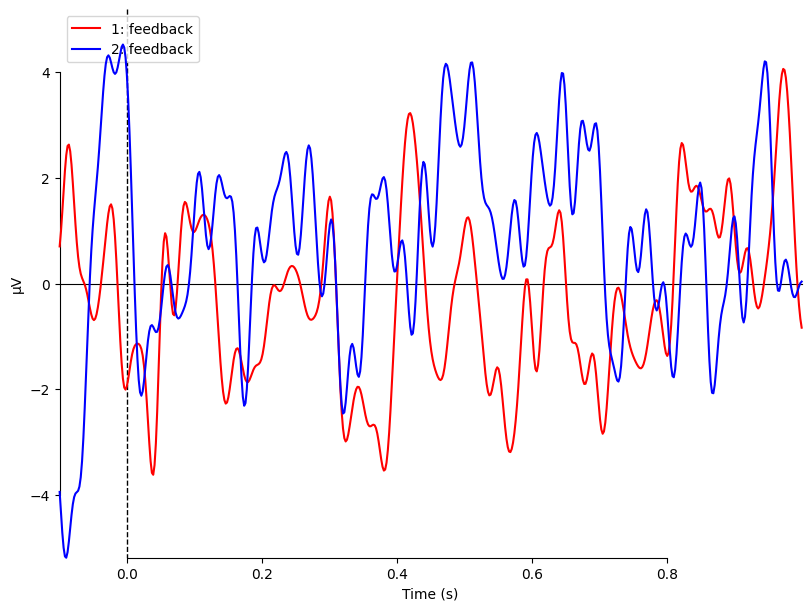

[<Figure size 800x600 with 1 Axes>]

In [241]:

wrong_feedback_epochs.crop(tmin=-0.1, tmax=1)
correct_feedback_epochs.crop(tmin=-0.1, tmax=1)
%matplotlib inline
mne.viz.plot_compare_evokeds([wrong_feedback_epochs.average(), correct_feedback_epochs.average()], colors = ['red', 'blue'], show_sensors=True)

Need more than one channel to make topography for eeg. Disabling interactivity.


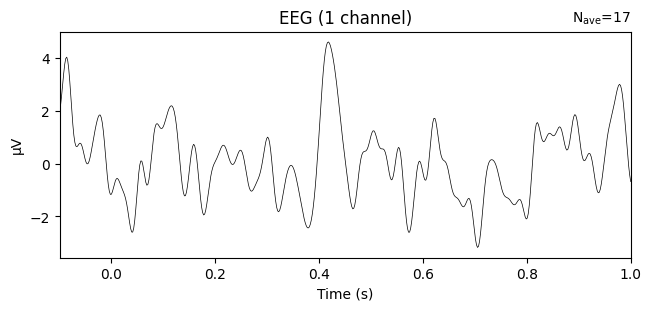

In [225]:
wrong_feedback_epochs.average().plot()
plt.show()

Need more than one channel to make topography for eeg. Disabling interactivity.


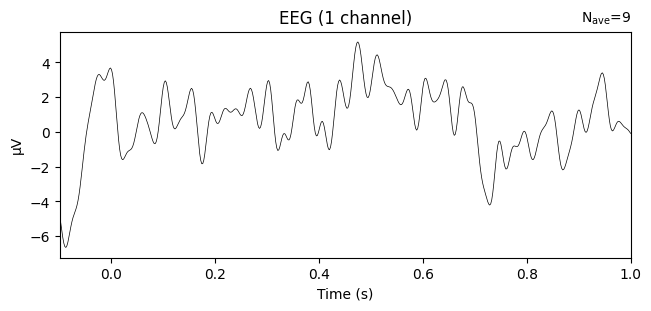

In [226]:
correct_feedback_epochs.average().plot()
plt.show()

# Motor activity visualization

In [118]:
# Make metadata
columns = ['response']
metadata_df = pd.DataFrame(columns=columns, index = None)
response = []
for i in range(len(events)):
    if events[i, 2] == event_id['left']:
        response.append('left')
    elif events[i, 2] == event_id['right']:
        response.append('right')
    elif events[i, 2] == event_id['rest']:
        response.append('rest')

metadata_df['response'] = response

In [119]:
# Create epochs
event_id = {'left': 140, 'right': 141, 'rest': 204}
event_of_interest = [140, 141, 204]
events = mne.pick_events(events, include=event_of_interest, exclude=None)
epochs = mne.Epochs(raw, events, event_id, tmin= -0.5, tmax= 2., preload=True, metadata=metadata_df, baseline = None)

Adding metadata with 1 columns
118 matching events found
No baseline correction applied
0 projection items activated
Loading data for 118 events and 1281 original time points ...
1 bad epochs dropped


In [120]:
%matplotlib qt
epochs.plot(n_epochs=10, n_channels=64)
plt.show()

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [121]:
epochs.metadata

,response
1,right
2,rest
3,right
4,rest
5,rest
...,...
113,left
114,rest
115,rest
116,left


In [133]:
# Vizualize mu and beta activity for different conditions on epochs
freqs = [8, 13, 20, 30]

epochs = epochs.filter(8, 30, method='iir', verbose=True)
power = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=2, return_itc=False, decim=3, n_jobs=1)
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
plt.show()

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Applying baseline correction (mode: logratio)


C:\Users\Emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:298: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
C:\Users\Emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:298: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
C:\Users\Emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:298: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
C:\Users\Emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:298: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [122]:
# Vizualize mu and beta activity
freqs = [("mu", 8, 12), ("beta", 13, 30)]
frequency_map = []
selected_channels = ['C3','C1','C2','C4','Cz','FC3','FC1','FC2' ,'FC4','FCz','CP3','CP1','CP2','CP4','CPz']
for band, fmin, fmax in freqs:
    # restrict the epochs to the given channels
    band_epochs = epochs.pick_channels(selected_channels)
    band_epochs.subtract_evoked()
    band_epochs = epochs.filter(fmin, fmax, fir_design='firwin')
    band_epochs.apply_hilbert(envelope=True)

    for cond in event_id.keys():
        frequency_map.append(((band, fmin, fmax), cond, band_epochs[f'response == "{cond}"'].average()))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)



C:\Users\Emile\AppData\Local\Temp\ipykernel_23016\4105285667.py:7: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  band_epochs = epochs.pick_channels(selected_channels)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 521 samples (1.018 s)



[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
C:\Users\Emile\AppData\Local\Temp\ipykernel_23016\4105285667.py:7: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  band_epochs = epochs.pick_channels(selected_channels)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:

In [123]:
frequency_map

[(('mu', 8, 12),
  'left',
  <Evoked | 'left' (average, N=20), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>),
 (('mu', 8, 12),
  'right',
  <Evoked | 'right' (average, N=20), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>),
 (('mu', 8, 12),
  'rest',
  <Evoked | 'rest' (average, N=77), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>),
 (('beta', 13, 30),
  'left',
  <Evoked | 'left' (average, N=20), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>),
 (('beta', 13, 30),
  'right',
  <Evoked | 'right' (average, N=20), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>),
 (('beta', 13, 30),
  'rest',
  <Evoked | 'rest' (average, N=77), -0.5 – 2 s, baseline off, 15 ch, ~192 kB>)]

In [124]:
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval

# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, len(frequency_map)))
for ((freq_name, fmin, fmax), condition,  average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name + ' ' + condition, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        f"{freq_name} ({fmin:d}-{fmax:d}Hz) {condition}",
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-500, 2000)

axes.ravel()[-1].set_xlabel("Time [ms]")

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
